In [9]:
!pip install polars

  Obtaining dependency information for polars from https://files.pythonhosted.org/packages/db/94/618144499355900ffe0f5e496819cb0266a9e1845b6653ae574bd7965dc3/polars-1.1.0-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 85.8 MB/s eta 0:00:00:00:0100:01


In [1]:
import glob
import tqdm
import numpy as np
import pandas as pd
import polars as pl
import dask.dataframe as dd
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
path = '/N/project/openalex/slices/subset-1990-2022/dec-2023/'
works_path = 'works'
works_authorships_path = 'works_authorships'
works_referenced_works_path = 'works_referenced_works'

In [3]:
works_dd = dd.read_parquet(path + works_path, calculate_divisions=True) #, npartitions=10)

In [4]:
works_br = pd.read_csv('works_br', sep='\t')
works_br.head()

,Unnamed: 0.1,Unnamed: 0,work_id,author_position,author_id,author_name,institution_lineage_level,institution_id,institution_name,country_code,is_corresponding,publication_year
0,45,1736429,186730611,first,5078262518,Guilherme Ribeiro,0,161460629,Universidade Federal Rural do Rio de Janeiro,BR,True,2014
1,46,1745057,193254257,first,5019917793,Maria Cecília Picinato,0,17974374,Universidade de São Paulo,BR,False,2001
2,174,1632607,206370407,first,5027925855,Eduardo André Perondi,0,4210126369,Polydoro Ernani de São Thiago University Hospital,BR,True,2007
3,529,1508716,222095242,first,5004541578,Reis Lc,0,879563668,Universidade Estadual Paulista (Unesp),BR,False,1996
4,547,643845,181667436,first,5070999666,Carlos Alberto Crespo de Souza,0,4210148245,Fundação Faculdade de Medicina,BR,False,1999


In [5]:
work_id_list = set(works_br['work_id'].values)

In [9]:
len(work_id_list)

2608997

In [13]:
references = dd.read_parquet(path + works_referenced_works_path)

In [8]:
references.head()

,work_id,referenced_work_id,work_publication_year,referenced_work_publication_year
4572360,4285386458,3699,2023,2008
2623263,197096146,524,2003,2002
306929,2082656788,524,2009,2002
180364,2134233184,4600,2012,2013
6169838,2001377875,4600,2013,2013


In [6]:
citations = references.groupby('referenced_work_id').count()

In [7]:
citations.head()

,work_id,work_publication_year,referenced_work_publication_year
referenced_work_id,,,
524,58,58,58
536,30,30,30
763,25,25,25
3699,117,117,117
4600,21,21,21


In [15]:
citations = citations.drop('work_id', axis=1)

In [16]:
citations.head()

,work_publication_year,referenced_work_publication_year
referenced_work_id,,
524,58,58
536,30,30
763,25,25
3699,117,117
4600,21,21


In [17]:
works_br_with_cits = dd.merge(works_br, citations, left_on='work_id', right_on='referenced_work_id').compute()

In [ ]:
len(works_br_with_cits)

In [18]:
works_br_with_cits.head()

,Unnamed: 0.1,Unnamed: 0,work_id,author_position,author_id,author_name,institution_lineage_level,institution_id,institution_name,country_code,is_corresponding,publication_year,work_publication_year,referenced_work_publication_year
0,174,1632607,206370407,first,5027925855,Eduardo André Perondi,0,4210126369,Polydoro Ernani de São Thiago University Hospital,BR,True,2007,32,32
1,529,1508716,222095242,first,5004541578,Reis Lc,0,879563668,Universidade Estadual Paulista (Unesp),BR,False,1996,1,1
2,937,542565,203236126,first,5063768457,Hugo Segawa,0,17974374,Universidade de São Paulo,BR,True,2012,1,1
3,1354,810942,200784480,middle,5020771058,John Soldera,0,130442723,Universidade Federal do Rio Grande do Sul,BR,False,2014,3,3
4,1355,810944,200784480,last,5059279422,Jacob Scharcanski,0,130442723,Universidade Federal do Rio Grande do Sul,BR,True,2014,3,3


In [ ]:
works_br_with_cits = works_br_with_cits.drop(['Unnamed: 0.1', 'Unnamed: 0', 'work_publication_year'], axis=1)

In [22]:
works_br_with_cits = works_br_with_cits.rename(columns={'referenced_work_publication_year': 'citations'})
works_br_with_cits.head()

,work_id,author_position,author_id,author_name,institution_lineage_level,institution_id,institution_name,country_code,is_corresponding,publication_year,citations
0,206370407,first,5027925855,Eduardo André Perondi,0,4210126369,Polydoro Ernani de São Thiago University Hospital,BR,True,2007,32
1,222095242,first,5004541578,Reis Lc,0,879563668,Universidade Estadual Paulista (Unesp),BR,False,1996,1
2,203236126,first,5063768457,Hugo Segawa,0,17974374,Universidade de São Paulo,BR,True,2012,1
3,200784480,middle,5020771058,John Soldera,0,130442723,Universidade Federal do Rio Grande do Sul,BR,False,2014,3
4,200784480,last,5059279422,Jacob Scharcanski,0,130442723,Universidade Federal do Rio Grande do Sul,BR,True,2014,3


In [ ]:
# salvar esse dataframe com works e citações
# verificar o que é referenced_work_id se é a contagem de citações

In [23]:
top_cit = works_br_with_cits[works_br_with_cits['citations'] >= 30]

In [24]:
top_cit.to_csv('top_cit_30')

In [26]:
top_cit_list = []
for work_id, infos in top_cit.groupby('work_id'):
    row = [work_id]
    row.append(infos.iloc[0]['citations'])
    row.append(list(infos['author_id']))
    row.append(list(infos['author_name']))
    top_cit_list.append(row)

top_cit_pd = pd.DataFrame(top_cit_list)
top_cit_pd.head()

,0,1,2,3
0,284616,132,"[5081043379, 5057915879, 5078603326, 501800369...","[Hans Fröder, Cristian Marlon de Magalhães Rod..."
1,481872,40,[5058721203],[Jesus Djalma Pécora]
2,670328,43,"[5071324973, 5066522889]","[Milene Heloisa Martins, Marco-Aurélio De Paoli]"
3,825380,39,"[5075552930, 5078083909]","[Sezimária de Fátima Pereira Saramago, Valder ..."
4,1169959,37,[5006424755],[Volker Bittrich]


In [27]:
top_cit_pd.columns = ['work_id', 'citations', 'authors_id', 'authors_name']

In [28]:
len(top_cit_pd) # total de artigos com 30 ou mais citações de autores brasileiros

171444

In [29]:
top_cit_pd = top_cit_pd.sort_values('citations', ascending=False)
top_cit_pd.to_csv('works_br_ascending_cit_ge30')

In [4]:
top_cit_pd = pd.read_csv('works_br_ascending_cit_ge30')

In [5]:
len(top_cit_pd)

171444

In [6]:
top_cit_pd.head()

,Unnamed: 0,work_id,citations,authors_id,authors_name
0,6524,1757407923,22790,[5045986275],['Marise Souto Rebelo']
1,154753,2909240409,6474,"[5021679179, 5049857343, 5057251977, 5057251977]","['Aldenor Gomes Santos', 'Gisele O. da Rocha',..."
2,114059,2149507322,6196,[5064307656],['Marinez Ferreira de Siqueira']
3,49252,2027545702,5941,[5071538514],['Fernando Lopes Gonçales']
4,143581,2748400555,5792,"[5030391700, 5010466306, 5045516086]","['Francisco Antônio Helfenstein Fonseca', 'Jos..."


In [8]:
top4000 = top_cit_pd.head(40)

In [9]:
top4000.head()

,Unnamed: 0,work_id,citations,authors_id,authors_name
0,6524,1757407923,22790,[5045986275],['Marise Souto Rebelo']
1,154753,2909240409,6474,"[5021679179, 5049857343, 5057251977, 5057251977]","['Aldenor Gomes Santos', 'Gisele O. da Rocha',..."
2,114059,2149507322,6196,[5064307656],['Marinez Ferreira de Siqueira']
3,49252,2027545702,5941,[5071538514],['Fernando Lopes Gonçales']
4,143581,2748400555,5792,"[5030391700, 5010466306, 5045516086]","['Francisco Antônio Helfenstein Fonseca', 'Jos..."


In [7]:
# disruption index
# authors_br = set(top_cit[top_cit['work_id'].isin(top4000['work_id'].values)]['author_id'].values)
# valid_works = dd.read_csv('works_valid_country', sep='\t')

# all_works_from_authors_br = valid_works[valid_works['author_id'].isin(authors_br)].compute()

In [8]:
# all_works_from_authors_br.to_csv('all_works_from_authors_br_top4000')

In [10]:
import pandas as pd 
from pathlib import Path
from tqdm.auto import tqdm
import time
import textwrap 
from rich import print
import pyarrow.parquet as pypq

if pd.__version__ >= '2.1':
  print('Using PyArrow strings!')
  pd.options.future.infer_string = True

def peek_parquet(path):
    """
    peeks at a parquet file (or a directory containing parquet files) and prints the following:
    * Path
    * schema
    * number of pieces (fragments)
    * number of rows 
    """
    if isinstance(path, str):
        path = Path(path)
        
    parq_file = pypq.ParquetDataset(path)
    piece_count = len(parq_file.fragments)
    schema = textwrap.indent(parq_file.schema.to_string(), ' '*4)
    row_count = sum(frag.count_rows() for frag in parq_file.fragments)
    
    st = [
        f'Name: {path.stem!r}',  
        f'Path: {str(path)!r}',
        f'Files: {piece_count:,}',
        f'Rows: {row_count:,}',
        f'Schema:\n{schema}',
        f'5 random rows:',
    ]
    print('\n'.join(st))
    sample_df = parq_file.fragments[0].head(5).to_pandas()  # read 5 rows from the first fragment
    display(sample_df)

    return

def read_parquet(path, engine='pyarrow', convert_dtypes=True, **args):
    """
    Read a parquet file
    """
    if isinstance(path, str):
        path = Path(path)

    if 'filters' in args:
        engine = 'pyarrow'
    
    if not path.name.endswith('.parquet'):
        ## check if a file exists without the extension 
        dir_exists = path.exists()
        if not dir_exists:  # try adding the parquet extension
            if path.with_suffix('.parquet').exists():
                path = path.with_suffix('.parquet')
                
    name = path.stem
        
    print(f'\nReading {name!r} from {str(path)!r} using {engine=}')

    tic = time.time()
    df = pd.read_parquet(path, engine=engine, **args)
    toc = time.time()
    print(f'Read {len(df):,} rows from {path.stem!r} in {toc-tic:.2f} sec.')
    
    if convert_dtypes:
        tic = time.time()
        size_before = df.memory_usage(deep=True).sum() / 1024 / 1024 / 1024

        string_cols_d = {}
        # string_type = 'string[python]'
        string_type = 'string[pyarrow]'
        for col, dtype in df.dtypes.to_dict().items():
            if pd.__version__ <= '2.1':
              if dtype == 'object' or dtype == 'string':  # convert object columns to string
                  string_cols_d[col] = string_type
            if col == 'type' or col == 'concept_name':
                if dtype != 'category':
                    string_cols_d[col] = 'category'
            if col == 'publication_month':
                if dtype != 'uint8':
                    string_cols_d[col] = 'uint8'
            if col == 'score':
                if dtype != 'float16':
                    string_cols_d[col] = 'float16'
                
        df = df.astype(string_cols_d) 
        
        size_after = df.memory_usage(deep=True).sum() / 1024 / 1024 / 1024
        toc = time.time()
        print(f'Converting dtypes took {toc-tic:.2f} sec. Size before: {size_before:.2f}GB, after: {size_after:.2f}GB')
    display(df.head(3))
    return df
    

Using PyArrow strings!

In [11]:
parq_basepath = Path('/N/project/openalex/slices/subset-1990-2022/dec-2023/')
peek_parquet(parq_basepath / 'works')

Name: 'works'
Path: '/N/project/openalex/slices/subset-1990-2022/dec-2023/works'
Files: 150
Rows: 186,789,669
Schema:
    doi: string
    title: string
    publication_year: int16
    publication_date: timestamp
    type: dictionary<values=string, indices=int32, ordered=0>
    type_crossref: dictionary<values=string, indices=int32, ordered=0>
    cited_by_count: uint32
    num_authors: uint16
    num_locations: uint16
    num_references: uint16
    language: string
    has_complete_institution_info: bool
    has_grant_info: bool
    has_keywords: bool
    created_date: timestamp
    updated_date: timestamp
    work_id: int64
    -- schema metadata --
    pandas: '{"index_columns": ["work_id"], "column_indexes": [{"name": null,' + 2387
5 random rows:

,doi,title,publication_year,publication_date,type,type_crossref,cited_by_count,num_authors,num_locations,num_references,language,has_complete_institution_info,has_grant_info,has_keywords,created_date,updated_date
work_id,,,,,,,,,,,,,,,,
9,NaN,Los peligros de atentado relativos al tráfico ...,2006,2006-01-01,article,journal-article,0,1,1,0,NaN,False,False,False,2016-06-24,2023-12-16 15:36:26.712
15,10.1007/978-3-642-32197-9_8,Führung und Delegation,2013,2013-01-01,book-chapter,book-chapter,0,2,1,0,de,True,False,True,2016-06-24,2023-12-16 15:38:19.283
23,NaN,Do patients with solid organ transplants or br...,2012,2012-01-01,article,journal-article,0,3,1,0,en,False,False,True,2016-06-24,2023-12-10 21:46:33.346
79,NaN,Ethno-medicinal survey among Malayali tribes o...,2009,2009-01-01,article,journal-article,0,2,1,0,en,False,False,True,2016-06-24,2023-12-11 01:10:27.279
87,NaN,Perspectivas culturales sobre la opinión públi...,2010,2010-01-01,article,journal-article,0,1,1,0,es,False,False,True,2016-06-24,2023-12-17 04:37:19.758


In [12]:
## get the work ids for the authors 
focal_papers_idxs = set(
    top4000['work_id'].values
)

focal_cits = read_parquet(
    parq_basepath / 'works_referenced_works',
    engine='pyarrow',
    columns=['work_id', 'referenced_work_id'],
    filters=[[('referenced_work_id', 'in', focal_papers_idxs)]],
)

focal_cits_idxs = set(
    focal_cits.work_id
)

potential_cits_of_cits = read_parquet(
    parq_basepath / 'works_referenced_works',
    engine='pyarrow',
    columns=['work_id', 'referenced_work_id'],
    filters=[[('referenced_work_id', 'in', focal_cits_idxs)]],
)
print(f'{len(focal_cits_idxs)=:,}')

Reading 'works_referenced_works' from '/N/project/openalex/slices/subset-1990-2022/dec-2023/works_referenced_works'
using engine='pyarrow'

Read 195,338 rows from 'works_referenced_works' in 34.67 sec.

Converting dtypes took 0.00 sec. Size before: 0.00GB, after: 0.00GB

,work_id,referenced_work_id
__null_dask_index__,,
1366160,2769347416,1757407923
1167880,2769790736,1757407923
3444298,2764321466,1757407923


Reading 'works_referenced_works' from '/N/project/openalex/slices/subset-1990-2022/dec-2023/works_referenced_works'
using engine='pyarrow'

Read 6,406,979 rows from 'works_referenced_works' in 28.78 sec.

Converting dtypes took 0.01 sec. Size before: 0.14GB, after: 0.14GB

,work_id,referenced_work_id
__null_dask_index__,,
9286891,2965139175,748993927
205024,3046325021,748993927
7441280,3157408288,748993927


len(focal_cits_idxs)=188,533

In [34]:
works_br_year = read_parquet(
    parq_basepath / 'works',
    engine='pyarrow',
    columns=['work_id', 'publication_year'],
    filters=[[('work_id', 'in', focal_papers_idxs | focal_cits_idxs)]],
)

Reading 'works' from '/N/project/openalex/slices/subset-1990-2022/dec-2023/works' using engine='pyarrow'

Read 188,564 rows from 'works' in 2.55 sec.

Converting dtypes took 0.00 sec. Size before: 0.00GB, after: 0.00GB

,publication_year
work_id,
340578,2011
514065,2005
560964,2007


In [ ]:
# focal_papers_idxs = set(top4000['work_id']) #.values)
# focal_cits = references[references['referenced_work_id'].isin(focal_papers_idxs)].compute()
# focal_cits_idxs = set(focal_cits['work_id'].values)
# potential_cits_of_cits = references[references['referenced_work_id'].isin(focal_cits_idxs)].compute()

In [ ]:
# potential_cits_of_cits.to_csv('potential_cits_of_cits_sample', sep='\t')

In [14]:
refs = read_parquet(
    parq_basepath / 'works_referenced_works',
    engine='pyarrow',
    columns=['work_id', 'referenced_work_id'],
    filters=[[('work_id', 'in', focal_papers_idxs)]],
)

Reading 'works_referenced_works' from '/N/project/openalex/slices/subset-1990-2022/dec-2023/works_referenced_works'
using engine='pyarrow'

Read 4,233 rows from 'works_referenced_works' in 20.09 sec.

Converting dtypes took 0.00 sec. Size before: 0.00GB, after: 0.00GB

,work_id,referenced_work_id
__null_dask_index__,,
74064,2105321265,144336581
74065,2105321265,1981119137
74066,2105321265,2005501262


In [ ]:
# refs = references[references['work_id'].isin(focal_papers_idxs)].compute()

In [15]:
def get_disruption_idx1(focal_cits, focal_refs):
    idx_numerator = 0
    test = potential_cits_of_cits[potential_cits_of_cits['work_id'].isin(focal_cits)]
    for paper, paper_refs in test.groupby('work_id'):
        a1 = set(paper_refs['referenced_work_id'].values)
        intersection = a1 & set(focal_refs['referenced_work_id'].values)
        f_it = 1
        if len(intersection) > 0:
            b_it = 1
        else:
            b_it = 0
    
        idx_numerator += -2*f_it*b_it + f_it    
    
    
    idx_denominator = len(focal_cits)
    disruption_idx = idx_numerator/idx_denominator
    return disruption_idx

In [ ]:
'''paper_disruption = []
i = 0
# ainda nao tem janela de tempo de 5 anos depois do artigo publicado
for paper_id, focal_paper_cits in focal_cits.groupby('referenced_work_id'):
    print(i, end='\r')
    i += 1
    total_cits = len(focal_paper_cits)
    focal_paper_cits = focal_paper_cits[focal_paper_cits['work_publication_year'] - focal_paper_cits['referenced_work_publication_year'] <= 5]
    focal_paper_cits = set(focal_paper_cits['work_id'])
    focal_refs = refs[refs['work_id'] == paper_id]
    
    if len(focal_refs) == 0 or len(focal_paper_cits) < 30:
        continue
    disr_idx = get_disruption_idx1(focal_paper_cits, focal_refs)
    paper_disruption.append((paper_id, disr_idx, len(focal_refs), total_cits, len(focal_paper_cits)))
'''

In [70]:
from dask.multiprocessing import get
# from tqdm.auto import tqdm 
from tqdm import tqdm

tqdm.pandas()
def bla(focal_paper_cits):
    #global refs
    paper_id = focal_paper_cits['referenced_work_id'].iloc[0]

    focal_paper_cits = focal_paper_cits.merge(works_br_year, how='left',left_on='work_id',right_on='work_id')
    year = works_br_year.loc[paper_id]['publication_year']
    total_cits = len(focal_paper_cits)
    focal_paper_cits = focal_paper_cits[focal_paper_cits['publication_year'] - year <= 5]
    focal_paper_cits = set(focal_paper_cits['work_id'])
    focal_refs = refs[refs['work_id'] == paper_id]
    
    if len(focal_refs) == 0:
        print('focal_refs == 0')
        return None, None #, None, None, None
    if len(focal_paper_cits) < 30:
        print('focal_paper_cits 30')
        return None, None #, None, None, None
    disr_idx = get_disruption_idx1(focal_paper_cits, focal_refs)
    return paper_id, disr_idx #, len(focal_refs), total_cits, len(focal_paper_cits)

# paper_disruption = []
i = 0

# ainda nao tem janela de tempo de 5 anos depois do artigo publicado

paper_disruption = focal_cits.groupby('referenced_work_id').progress_apply(bla)


  0%|          | 0/40 [00:00<?, ?it/s]

In [48]:
len(paper_disruption)

40

In [69]:
paper_disruption.head(10)

referenced_work_id
1757407923     (1757407923, 0.4913170325090303)
1968105193     (1968105193, 0.8301237964236589)
1993397663     (1993397663, 0.6270783847980997)
2003949305     (2003949305, 0.4176470588235294)
2014886338    (2014886338, 0.47118023787740165)
2021908094     (2021908094, 0.7512291052114061)
2027545702     (2027545702, 0.7855603448275862)
2038754799     (2038754799, 0.4616822429906542)
2040340473     (2040340473, 0.5550496688741722)
2045287414     (2045287414, 0.5126705653021443)
dtype: object

In [ ]:
paper_disruption.head()

In [ ]:
paper_disruption_pd = pd.DataFrame(paper_disruption)
paper_disruption_pd.columns = ['work_id', 'disruption', 'refs', 'cits', 'citations5']
paper_disruption_pd.head(10)

In [ ]:
paper_infos_disr = pd.merge(paper_disruption_pd, top4000, on='work_id')
paper_infos_disr.head(10)

In [ ]:
paper_infos_disr = paper_infos_disr.sort_values('disruption', ascending=False)

In [ ]:
# paper_infos_disr.to_csv('top4000cits_infos_with_disruption')
paper_infos_disr.to_csv('cits_infos_with_disruption')

In [75]:
X = [x for x,y,z,w,_ in paper_disruption]
Y = [y for x,y,z,w,_ in paper_disruption] # disruption
Z = [z for x,y,z,w,_ in paper_disruption] # refs
W = [w for x,y,z,w,_ in paper_disruption] # cits
WW = [w for x,y,z,_,w in paper_disruption] # cits 5

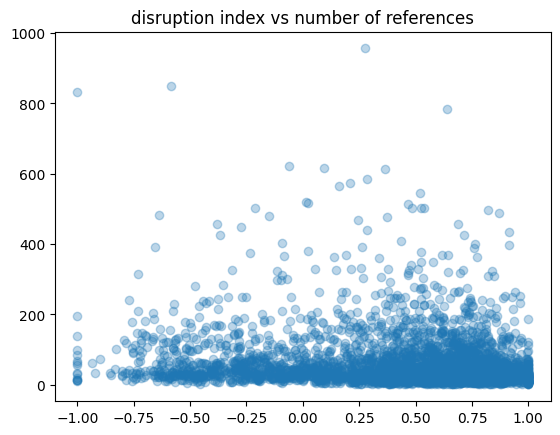

In [70]:
plt.scatter(Y, Z, alpha=0.3)
plt.title('disruption index vs number of references')
plt.show()

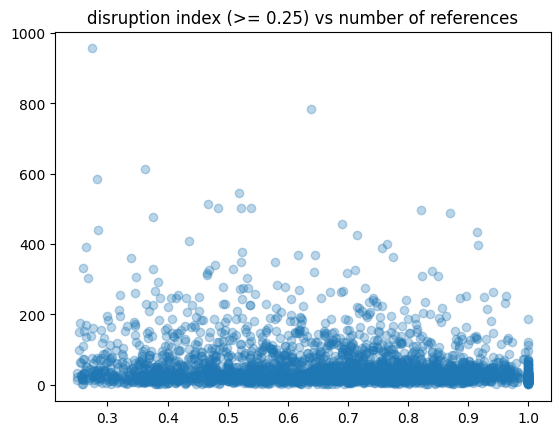

In [71]:
plt.scatter([y for y in Y if y >= 0.25], [z for y,z in zip(Y,Z) if y >= 0.25], alpha=0.3)
plt.title('disruption index (>= 0.25) vs number of references')
plt.show()

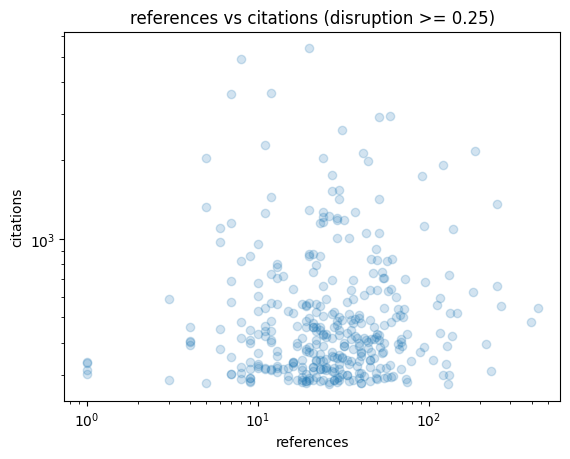

In [79]:
plt.scatter([z for y, z in zip(Y,Z) if y >= 0.9], [w for y, w in zip(Y,W) if y >= 0.9], alpha=0.2)
plt.yscale('log')
plt.xscale('log')
plt.title('references vs citations (disruption >= 0.25)')
plt.xlabel('references')
plt.ylabel('citations')
plt.show()

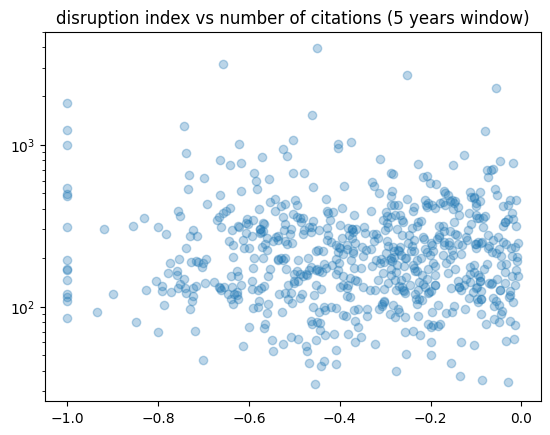

In [82]:
# plt.scatter(Y, WW, alpha=0.3)

plt.scatter([y for y in Y if y < 0], [w for y, w in zip(Y,WW) if y < 0], alpha=0.3)
plt.title('disruption index vs number of citations (5 years window)')
plt.yscale('log')
plt.show()

Text(0.5, 1.0, 'disruption dist')

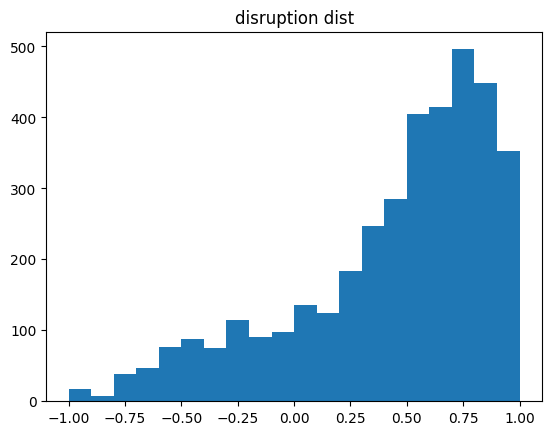

In [74]:
plt.hist(Y, bins=20)
plt.title('disruption dist')

In [54]:
paper_disruption_pd = pd.DataFrame(paper_disruption)
paper_disruption_pd.columns = ['work_id', 'disruption', 'refs', 'cits', 'cits5']

In [55]:
paper_disruption_pd.head()

,work_id,disruption,refs,cits,cits5
0,12080193,0.400000,6,295,30
1,27366642,0.557692,136,284,104
2,34264966,0.678161,82,354,87
3,64079490,0.917241,12,317,145
4,82112906,0.304348,74,565,253


In [3]:
def load_dict(filename):
    input_file = open(filename)
    file_dict = dict()
    for line in input_file:
        key, values = line[:-1].split('\t')
        values = values[1:-1].split(',')
        values = [int(v) for v in values]
        file_dict[int(key)] = values
    return file_dict

In [4]:
index2cited_index = load_dict('../adilson/index2cited_index')

In [5]:
index2citing_index = load_dict('../adilson/index2citing_index')

In [6]:
works_br = pd.read_csv('works_br', sep='\t')
works_br.head()

,Unnamed: 0.1,Unnamed: 0,work_id,author_position,author_id,author_name,institution_lineage_level,institution_id,institution_name,country_code,is_corresponding,publication_year
0,45,1736429,186730611,first,5078262518,Guilherme Ribeiro,0,161460629,Universidade Federal Rural do Rio de Janeiro,BR,True,2014
1,46,1745057,193254257,first,5019917793,Maria Cecília Picinato,0,17974374,Universidade de São Paulo,BR,False,2001
2,174,1632607,206370407,first,5027925855,Eduardo André Perondi,0,4210126369,Polydoro Ernani de São Thiago University Hospital,BR,True,2007
3,529,1508716,222095242,first,5004541578,Reis Lc,0,879563668,Universidade Estadual Paulista (Unesp),BR,False,1996
4,547,643845,181667436,first,5070999666,Carlos Alberto Crespo de Souza,0,4210148245,Fundação Faculdade de Medicina,BR,False,1999


In [7]:
focal_papers = set(works_br['work_id'])# ids dos artigos

In [ ]:
works_dd = dd.read_parquet(path + works_path, calculate_divisions=True)
index2ID = list(works_dd.index)
ID2index = {id: index for index, id in enumerate(index2ID)}

In [ ]:

def get_in(index): # ARTIGOS QUE CITARAM INDEX
    if index in index2cited_index:
        return index2cited_index[index]
    return []

def get_out(index): # ARTIGOS REFERENCIADOS POR INDEX / INDEX CITA
    if index in index2citing_index:
        return index2citing_index[index]
    return []
    
Dindex_list = []

for focal_paper in tqdm.tqdm(focal_papers, total=len(focal_papers)):
    focal_index = ID2index[focal_paper]
    if focal_index in index2citing_index: # focal_index precisa ter referencias
        #print(focal_paper)
    
        citing_focal_paper = get_in(focal_index)
        cited_by_focal_paper = set(get_out(focal_index))

        cited_by_citing_focal_paper = [set(get_out(paper_id)) for paper_id in citing_focal_paper]
        cited_by_citing_focal_paper = [cited_by_focal_paper & set(citing_list) for citing_list in cited_by_citing_focal_paper]
        
        citing_only_focal = 0
        citing_focal_and_refs_of_focal = 0
        for test in cited_by_citing_focal_paper:
            if len(test) > 0:
                citing_focal_and_refs_of_focal += 1
            else:
                citing_only_focal += 1        

        citing_refs_of_focal = [get_in(paper_id) for paper_id in cited_by_focal_paper]
        citing_refs_of_focal_set = set()
        for papers in citing_refs_of_focal:
            citing_refs_of_focal_set |= set(papers)
        citing_refs_of_focal_set = list(citing_refs_of_focal_set)
        citing_only_refs_of_focal = 0
        for paper in citing_refs_of_focal_set:
            paper_refs = get_out(paper)
            if focal_index not in paper_refs:
                citing_only_refs_of_focal += 1

        Dindex = (citing_only_focal - citing_focal_and_refs_of_focal)/(citing_only_focal + citing_focal_and_refs_of_focal + citing_only_refs_of_focal)
        # print(Dindex)
        Dindex_list.append((focal_paper, citing_only_focal, citing_focal_and_refs_of_focal, citing_only_refs_of_focal, Dindex))

pd.DataFrame(Dindex_list, columns=['paper_openalex_id', 'only_focal', 'focal_and_refs', 'only_refs', 'Dindex']).to_csv('Dindex_list_br')